In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#thread and progress bar
import concurrent.futures
from tqdm import tqdm

#preprocessing
import string
import re
string.punctuation
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

#plotting the data
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

#Model
from transformers import BertTokenizer, BertModel, TFBertModel, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import gc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Understanding BERT

This is just to show and understand the inner working of BERT transformer but won't be used as model for our data as BERT is already pre-trained and would be a waste to not take advantage of it

![BERT Schéma](https://drive.google.com/uc?export=view&id=1Iu_rP2pKieoOhe6xeKxVtlk0PCXGFXzN)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [5]:
class SimpleSelfAttention(torch.nn.Module):
    def __init__(self, embed_size):
        super(SimpleSelfAttention, self).__init__()
        self.embed_size = embed_size

        self.query_projection = nn.Linear(embed_size, embed_size)
        self.key_projection = nn.Linear(embed_size, embed_size)
        self.value_projection = nn.Linear(embed_size, embed_size)

        self.linear = nn.Linear(embed_size, embed_size)
        self.relu = nn.ReLU()

        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        # Project the input to obtain queries, keys, and values
        queries = self.query_projection(x)
        keys = self.key_projection(x)
        values = self.value_projection(x)

        # Compute scaled dot-product attention
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_scores = attention_scores / np.sqrt(self.embed_size)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply attention to values
        output = torch.matmul(attention_weights, values)

        # Add & Norm Layer
        output = self.layer_norm1(x + output)

        # Additional feedforward layer with ReLU activation
        output = self.linear(self.relu(self.linear(output)))

        # Add & Norm Layer
        output = self.layer_norm2(x + output)

        return output

class SimpleSelfAttentionClassifier(torch.nn.Module):
    def __init__(self, embed_size, num_classes):
        super(SimpleSelfAttentionClassifier, self).__init__()
        self.self_attention = SimpleSelfAttention(embed_size)
        self.classification = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        # Apply self-attention
        attention_output = self.self_attention(x)

        # Global average pooling to get a fixed-size representation
        pooled_output = attention_output.mean(dim=1)

        # Classification layer
        logits = self.classification(pooled_output)
        return logits

In [6]:
embed_size = 64 #each token is a 64-d vector

# Create an instance of the model
attention_model = SimpleSelfAttention(embed_size)

# Example input
batch_size = 16 #during one iteration, 16 training examples simultaneously
sequence_length = 10
input_data = torch.randn(batch_size, sequence_length, embed_size)

# Forward pass through the attention model
output = attention_model(input_data)

print("Input shape:", input_data.shape)
print("Output shape:", output.shape)


Input shape: torch.Size([16, 10, 64])
Output shape: torch.Size([16, 10, 64])


# Dataset utils

In [7]:
def preprocess_text(text, remove_stopwords=True, remove_punctuation=True, remove_html=True):
    # Convert to lowercase
    text = text.lower()

    # Optionally remove HTML tags
    if remove_html:
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[\n\r\t]', ' ', text)

    # Optionally remove punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Optionally remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        words = [word for word in words if word.lower() not in stop_words]
        text = ' '.join(words)

    return text

In [8]:
# Function to apply preprocessing to a specific column with a progress bar
def apply_preprocessing_with_progress(df, column_name, stopwords=True, punctuation=True, html=True):
    tqdm.pandas(desc=f"Processing {column_name}", position=0, leave=False)
    # Apply preprocess_text function to all the data
    df[column_name] = df[column_name].progress_apply(lambda x: preprocess_text(x, remove_stopwords=stopwords, remove_punctuation=punctuation, remove_html=html))

In [9]:
# Function to generate worldcould
def gerenate_worldcloud(df, label, column,remove_common_words=True):

  txt_string = ' '.join(df[df['label']==label][column])

  if remove_common_words:
      common_words = ["said", "say", "one"]
      for word in common_words:
          txt_string = txt_string.replace(word, '')

  wordcloud = WordCloud()
  wordcloud.generate(txt_string)
  plt.imshow(wordcloud.to_image())
  plt.axis('off')
  plt.title(f'Worldcould for {column} with the verdict: {label}')
  plt.show()

In [10]:
# Function to get top bigrams and plot it
def plot_top_bigram(df, label, column, remove_common_words=True, top_n=5):

  txt = ' '.join(df[df['label']==label][column])

  if remove_common_words:
      common_words = ["said", "say", "one", '“', '”']
      for word in common_words:
          txt = txt.replace(word, '')

  # Tokenize the text into words
  words = word_tokenize(txt.lower())

  # Generate bigrams
  bigrams_list = list(bigrams(words))

  # Count the occurrences of each bigram
  bigram_counts = {}
  for bigram in bigrams_list:
      if bigram in bigram_counts:
          bigram_counts[bigram] += 1
      else:
          bigram_counts[bigram] = 1

  # Get the top N bigrams
  top_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

  labels, counts = zip(*[(f"{bigram[0]} {bigram[1]}", count) for bigram, count in top_bigrams])

  # Plot the top bigrams
  plt.figure(figsize=(10, 6))
  plt.barh(labels, counts, color='skyblue')
  plt.xlabel('Frequency')
  plt.ylabel('Bigrams')
  plt.title(f'Top {top_n} Bigrams for {column} with the verdict: {label}')
  plt.show()

# Fever Corpus

## Exploration and preprocessing

In [11]:
fever = pd.read_csv('drive/MyDrive/Colab Notebooks/TB/fever_downsampled.csv')

In [12]:
fever

,Unnamed: 0,label,claim,evidence,numerical_label,ETS,Documents
0,28827,SUPPORTS,Gianluigi Buffon won an award for goalkeeping.,"[[[191400, 202269, 'Gianluigi_Buffon', 22]]]",1,He was the first ever goalkeeper to win the G...,Gianluigi Buffon (Italian pronunciation: [dʒa...
1,1627,SUPPORTS,Colin Farrell starred in Minority Report.,"[[[189789, 201002, 'Colin_Farrell', 3]]]",1,Farrell began acting in the BBC drama series B...,Colin James Farrell (; born 31 May 1976) is an...
2,11585,SUPPORTS,Jon Huntsman Jr. is a politician and a busines...,"[[[73998, 85234, 'Jon_Huntsman_Jr.', 0]], [[79...",1,Jon Meade Huntsman Jr. Jon Meade Huntsman Jr,"Jon Meade Huntsman Jr. (born March 26, 1960) i..."
3,67618,SUPPORTS,Reg Watson created Neighbours.,"[[[208957, 216891, 'Reg_Watson', 0]], [[208998...",1,Reginald James Watson (27 August 1926 – 8 Oct...,Reginald James Watson (27 August 1926 – 8 Oct...
4,80259,SUPPORTS,Harry Potter was written by an Englishwoman.,"[[[213932, 221047, 'Harry_Potter', 0], [213932...",1,Error: Wiki page not found (get_wikipedia_data),Error: Wiki page not found (get_wikipedia_data)
...,...,...,...,...,...,...,...
10779,128884,REFUTES,Darius Rucker is only a back up vocalist in Ho...,"[[[205027, 213668, 'Darius_Rucker', 1]]]",0,He first gained fame as the lead vocalist and...,"Darius Rucker (born May 13, 1966) is an Americ..."
10780,47116,REFUTES,"Curse, Inc. has only ever been used by the gam...","[[[216684, 223357, 'Curse,_Inc.', 3]]]",0,"As it expanded, the company began to develop ...",Curse was a gaming company that managed the vi...
10781,105670,REFUTES,The Olympic Games has nearly 400 kittens.,"[[[68603, 79466, 'Olympic_Games', 23]]]",0,\n\n\n== Ancient Olympics ==\n\nThe Ancient Ol...,The modern Olympic Games or Olympics (French: ...
10782,26902,REFUTES,Broadchurch is a silent film.,"[[[286737, 280196, 'Broadchurch', 0]], [[28891...",0,Broad church is latitudinarian churchmanship i...,Broad church is latitudinarian churchmanship i...


In [13]:
print(fever.columns)
print(fever.isnull().any())
print(fever.shape)

Index(['Unnamed: 0', 'label', 'claim', 'evidence', 'numerical_label', 'ETS',
       'Documents'],
      dtype='object')
Unnamed: 0         False
label              False
claim              False
evidence           False
numerical_label    False
ETS                 True
Documents          False
dtype: bool
(10784, 7)


In [14]:
fever.dropna(inplace=True)

In [15]:
print(fever.isnull().any())

Unnamed: 0         False
label              False
claim              False
evidence           False
numerical_label    False
ETS                False
Documents          False
dtype: bool


In [16]:
error_rows = fever[fever['ETS'].str.startswith('Error')]
error_rows

,Unnamed: 0,label,claim,evidence,numerical_label,ETS,Documents
4,80259,SUPPORTS,Harry Potter was written by an Englishwoman.,"[[[213932, 221047, 'Harry_Potter', 0], [213932...",1,Error: Wiki page not found (get_wikipedia_data),Error: Wiki page not found (get_wikipedia_data)
56,87689,SUPPORTS,San Junipero is science fiction.,"[[[71553, 82539, 'San_Junipero', 0]]]",1,Error: Wiki page not found (get_wikipedia_data),Error: Wiki page not found (get_wikipedia_data)
57,9761,SUPPORTS,Young MC is a singer.,"[[[232942, 235991, 'Young_MC', 0]]]",1,Error: Wiki page not found (get_wikipedia_data),Error: Wiki page not found (get_wikipedia_data)
59,60374,SUPPORTS,"As the Vietnam War raged in Southeast Asia, Yo...","[[[234878, 237673, 'Bed-In', 0]], [[237662, 23...",1,Error: Wiki page not found (get_wikipedia_data...,Error: Wiki page not found (get_wikipedia_data)
78,42701,SUPPORTS,Futurama is a science fiction animated series ...,"[[[83532, 95522, 'Futurama', 0], [83532, 95522...",1,Error: Wiki page not found (get_wikipedia_data),Error: Wiki page not found (get_wikipedia_data)
...,...,...,...,...,...,...,...
10745,84720,REFUTES,Brokeback Mountain was directed by Francis For...,"[[[209645, 217430, 'Brokeback_Mountain', 0]]]",0,Error: Wiki page not found (get_wikipedia_data),Error: Wiki page not found (get_wikipedia_data)
10747,121902,REFUTES,"J. J. Cale died on July 26, 2003.","[[[59672, 70083, 'J._J._Cale', 0]]]",0,Error: Wiki page not found (get_wikipedia_data),Error: Wiki page not found (get_wikipedia_data)
10748,137835,REFUTES,Cannibalism is the act of humans burning the f...,"[[[191768, 202565, 'Cannibalism', 0]]]",0,Error: Wiki page not found (get_wikipedia_data),Error: Wiki page not found (get_wikipedia_data)
10772,42467,REFUTES,Jeff Bezos was born in February.,"[[[45011, 53719, 'Jeff_Bezos', 0]]]",0,Error: Wiki page not found (get_wikipedia_data),Error: Wiki page not found (get_wikipedia_data)


It seems some ETS where not correctly extracted, let's remove them

In [17]:
fever.drop(error_rows.index, inplace=True)

In [18]:
if any(fever['ETS'].str.startswith('Error')):
    print("True")
else:
    print("False")

fever

False


,Unnamed: 0,label,claim,evidence,numerical_label,ETS,Documents
0,28827,SUPPORTS,Gianluigi Buffon won an award for goalkeeping.,"[[[191400, 202269, 'Gianluigi_Buffon', 22]]]",1,He was the first ever goalkeeper to win the G...,Gianluigi Buffon (Italian pronunciation: [dʒa...
1,1627,SUPPORTS,Colin Farrell starred in Minority Report.,"[[[189789, 201002, 'Colin_Farrell', 3]]]",1,Farrell began acting in the BBC drama series B...,Colin James Farrell (; born 31 May 1976) is an...
2,11585,SUPPORTS,Jon Huntsman Jr. is a politician and a busines...,"[[[73998, 85234, 'Jon_Huntsman_Jr.', 0]], [[79...",1,Jon Meade Huntsman Jr. Jon Meade Huntsman Jr,"Jon Meade Huntsman Jr. (born March 26, 1960) i..."
3,67618,SUPPORTS,Reg Watson created Neighbours.,"[[[208957, 216891, 'Reg_Watson', 0]], [[208998...",1,Reginald James Watson (27 August 1926 – 8 Oct...,Reginald James Watson (27 August 1926 – 8 Oct...
5,29266,SUPPORTS,Tiger Woods won a tournament.,"[[[114776, 128513, 'Tiger_Woods', 5]], [[11477...",1,"By the end of April 1997, he had won three PG...","Eldrick Tont ""Tiger"" Woods (born December 30, ..."
...,...,...,...,...,...,...,...
10779,128884,REFUTES,Darius Rucker is only a back up vocalist in Ho...,"[[[205027, 213668, 'Darius_Rucker', 1]]]",0,He first gained fame as the lead vocalist and...,"Darius Rucker (born May 13, 1966) is an Americ..."
10780,47116,REFUTES,"Curse, Inc. has only ever been used by the gam...","[[[216684, 223357, 'Curse,_Inc.', 3]]]",0,"As it expanded, the company began to develop ...",Curse was a gaming company that managed the vi...
10781,105670,REFUTES,The Olympic Games has nearly 400 kittens.,"[[[68603, 79466, 'Olympic_Games', 23]]]",0,\n\n\n== Ancient Olympics ==\n\nThe Ancient Ol...,The modern Olympic Games or Olympics (French: ...
10782,26902,REFUTES,Broadchurch is a silent film.,"[[[286737, 280196, 'Broadchurch', 0]], [[28891...",0,Broad church is latitudinarian churchmanship i...,Broad church is latitudinarian churchmanship i...


It seems the extraction for some ETS wasn't clean enough and terms such as "Jr." cut some sentences in the middle because the split being made on the point... For example:

In [19]:
bad_ETS = fever.loc[10783, 'ETS']
print(f'Example of bad ETS: "{bad_ETS}"  of length {len(bad_ETS)}')

Example of bad ETS: "Calvin Cordozar Broadus Jr"  of length 26


Let's see the length of all ETS:

In [20]:
fever['ETS_length'] = fever['ETS'].apply(lambda x: len(str(x)))
sorted_fever = fever.sort_values(by='ETS_length', ascending=True)

print('10 shortest ETS :')
print(sorted_fever.head(10)[['ETS_length', 'ETS']])

10 shortest ETS :
      ETS_length ETS
6829           1   S
9513           1   N
9808           1   S
2758           1   W
7336           1   S
9810           1   S
7119           1   N
8173           1   m
1689           1   S
5513           1   A


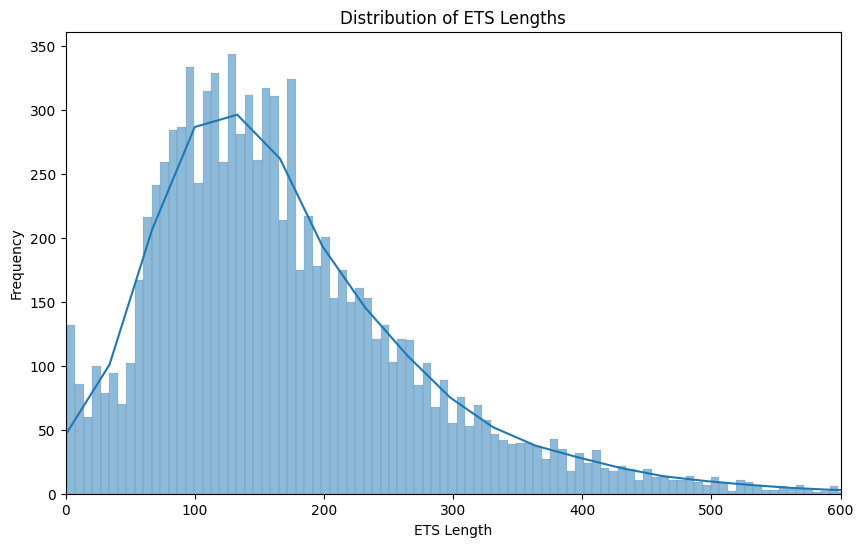

In [21]:
# Plot the distribution of ETS lengths
plt.figure(figsize=(10, 6))
sns.histplot(fever['ETS_length'], bins=1000, kde=True)
plt.title('Distribution of ETS Lengths')
plt.xlabel('ETS Length')
plt.ylabel('Frequency')

plt.xlim(0, 600)

plt.show()

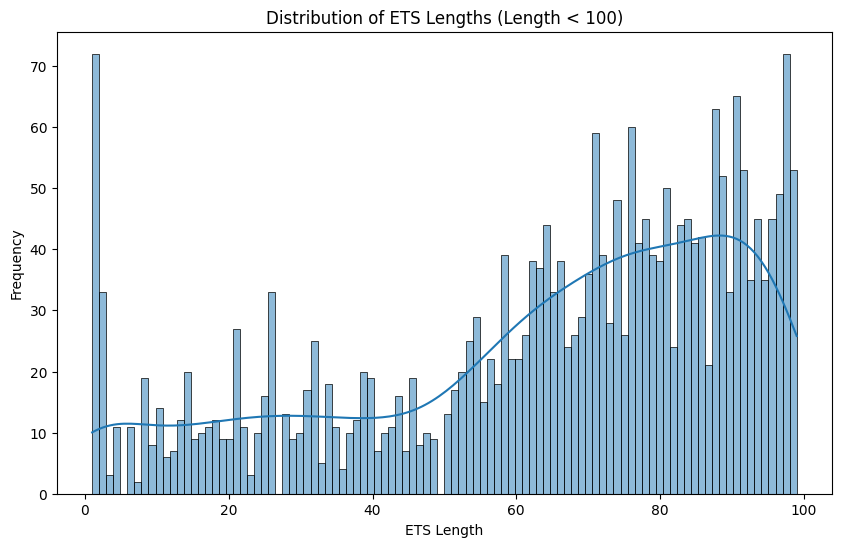

In [22]:
fever_subset = fever[fever['ETS_length'] < 100]

plt.figure(figsize=(10, 6))
sns.histplot(fever_subset['ETS_length'], bins=100, kde=True)
plt.title('Distribution of ETS Lengths (Length < 100)')
plt.xlabel('ETS Length')
plt.ylabel('Frequency')

plt.show()

It seems that most of the incorect ETS are between length 1 and 50. Let's print one of each to see.

In [23]:
for length in range(1,101):
    examples = fever[fever['ETS_length'] == length]['ETS'].head(1)

    if not examples.empty:
        print(f'Length {length}: {examples.values[0]}')
    else:
        print(f'Length {length}: No examples found.')

Length 1: S
Length 2:  R
Length 3: " R
Length 4: S. S
Length 5: No examples found.
Length 6: Mr. Mr
Length 7: Star vs
Length 8:  Records
Length 9: 4 million
Length 10: 344 metres
Length 11: 022-mile (8
Length 12: Taal (transl
Length 13:  Eugene Landy
Length 14:  Weiss for HBO
Length 15:  Produced by Dr
Length 16:  carbon dioxide)
Length 17: Genre (UK: /ˈʒɑ̃ː
Length 18:  Records.  Records
Length 19:  television ratings
Length 20: James Evan Wilson, M
Length 21:  Fisher Unwin in 1908
Length 22:  Schaffner.  Schaffner
Length 23:  Marlene King and Amy B
Length 24: Leslie Richard Groves Jr
Length 25:  It stars the voices of T
Length 26:  Their mother died in 2008
Length 27: No examples found.
Length 28: Deus (Classical Latin: [ˈd̪e
Length 29:  He also performs in cabarets
Length 30:  In 2019, there were about 140
Length 31:  It is owned by The Times Group
Length 32:  became part of the Bandai Group
Length 33:  In 1948, he was elected to the U
Length 34:  Total reserves are estimated at 3
Le

In [24]:
examples_by_length = fever[fever['ETS_length'] == 50]['ETS']

for example in examples_by_length:
    print(example)

Observer Media is an American online media company
Observer Media is an American online media company
Observer Media is an American online media company
Shaka kaSenzangakhona (c. Shaka kaSenzangakhona (c
Wentworth is an Australian television drama series
 The club plays its home games at the Chase Center
 Increasing inequality led to more social conflict
 The club plays its home games at the Chase Center
Wentworth is an Australian television drama series
 Hamilton's father later set up his own IT company
Wentworth is an Australian television drama series



== Early life and education ==
Marlon Brando Jr
Shaka kaSenzangakhona (c. Shaka kaSenzangakhona (c


It looks like an ETS with length smaller than 50 tends to be wrongly extracted (incomplete, empty, etc.) so let's remove all rows with ETS shorter than 50

In [25]:
fever = fever[fever['ETS_length'] >= 50]

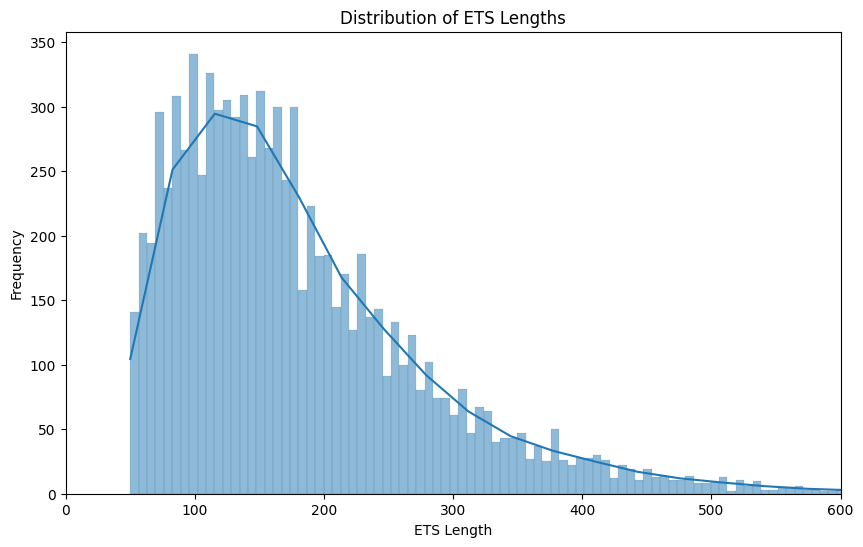

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(fever['ETS_length'], bins=1000, kde=True)
plt.title('Distribution of ETS Lengths')
plt.xlabel('ETS Length')
plt.ylabel('Frequency')

plt.xlim(0, 600)

plt.show()

Now the graph is a nice curve without any weird spikes at the begining

Finally, let's remove all the HTML text in the ETS (punctuation and stopwords are kept as BERT tokenizer deals with it) :

In [27]:
columns_to_process = ['ETS', 'claim']

# Use concurrent.futures to run the process in parallel
with concurrent.futures.ThreadPoolExecutor() as executor_fever1:
    # Submit the tasks for each column
    futures = [executor_fever1.submit(apply_preprocessing_with_progress, fever,column_name, stopwords=False, punctuation=False) for column_name in columns_to_process]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

<ipython-input-8-f9f5a919d4c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].progress_apply(lambda x: preprocess_text(x, remove_stopwords=stopwords, remove_punctuation=punctuation, remove_html=html))


In [28]:
print(fever['label'].value_counts(normalize=False))
print(fever['label'].value_counts(normalize=True))

SUPPORTS    7312
REFUTES     1649
Name: label, dtype: int64
SUPPORTS    0.81598
REFUTES     0.18402
Name: label, dtype: float64


The FEVER corpus is unbalenced in favor of SUPPORT claims

In [29]:
fever['label'] = fever['label'].replace({"SUPPORTS": "TRUE", "REFUTES": "FALSE"})

<ipython-input-29-4cef73df2731>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fever['label'] = fever['label'].replace({"SUPPORTS": "TRUE", "REFUTES": "FALSE"})


In [30]:
fever = fever.drop(columns=['Unnamed: 0', 'evidence', 'ETS_length', 'Documents'])

In [31]:
fever

,label,claim,numerical_label,ETS
0,TRUE,gianluigi buffon won an award for goalkeeping.,1,he was the first ever goalkeeper to win the g...
1,TRUE,colin farrell starred in minority report.,1,farrell began acting in the bbc drama series b...
3,TRUE,reg watson created neighbours.,1,reginald james watson (27 august 1926 – 8 oct...
5,TRUE,tiger woods won a tournament.,1,"by the end of april 1997, he had won three pg..."
7,TRUE,nicki minaj has not won a grammy.,1,"outside of music, her film and television car..."
...,...,...,...,...
10778,FALSE,frank ocean released a concert album.,0,"ocean self-released his second studio album, ..."
10779,FALSE,darius rucker is only a back up vocalist in ho...,0,he first gained fame as the lead vocalist and...
10780,FALSE,"curse, inc. has only ever been used by the gam...",0,"as it expanded, the company began to develop ..."
10781,FALSE,the olympic games has nearly 400 kittens.,0,== ancient olympics == the ancient olympic...


## WordCloud & Top Bigrams

> To create worldclounds and a plot of the bigrams it is necessary to remove punctuation and stopwords so relevant information can be shown. This is done on a copy of the data



In [32]:
fever_filtered = fever.copy()

In [33]:
columns_to_process = ['ETS', 'claim']

# Use concurrent.futures to run the process in parallel
with concurrent.futures.ThreadPoolExecutor() as executor_fever2:
    # Submit the tasks for each column
    futures = [executor_fever2.submit(apply_preprocessing_with_progress, fever_filtered ,column_name, stopwords=True) for column_name in columns_to_process]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

In [34]:
fever_filtered

,label,claim,numerical_label,ETS
0,TRUE,gianluigi buffon award goalkeeping,1,first ever goalkeeper win golden foot award al...
1,TRUE,colin farrell starred minority report,1,farrell began acting bbc drama series ballykis...
3,TRUE,reg watson created neighbours,1,reginald james watson 27 august 1926 – 8 octob...
5,TRUE,tiger woods tournament,1,end april 1997 three pga tour events addition ...
7,TRUE,nicki minaj grammy,1,outside music film television career included ...
...,...,...,...,...
10778,FALSE,frank ocean released concert album,0,ocean selfreleased second studio album blonde ...
10779,FALSE,darius rucker back vocalist hootie blowfish,0,first gained fame lead vocalist rhythm guitari...
10780,FALSE,curse inc ever used game kirby air ride,0,expanded company began develop acquire gaming ...
10781,FALSE,olympic games nearly 400 kittens,0,ancient olympics ancient olympic games ancient...


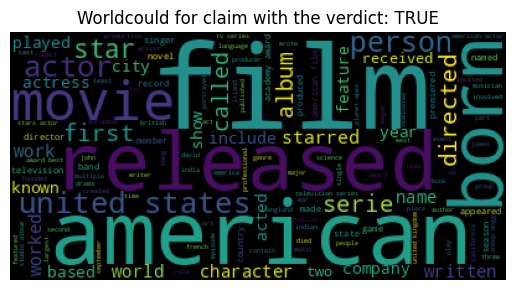

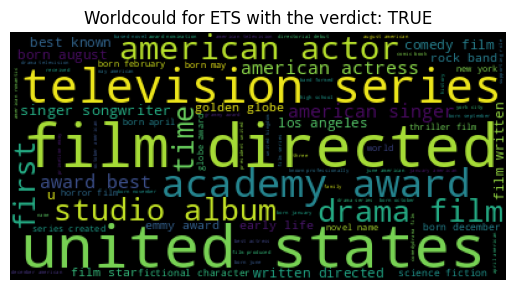

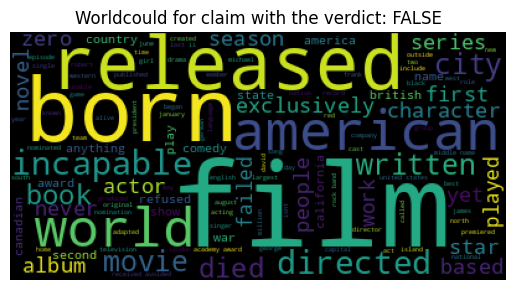

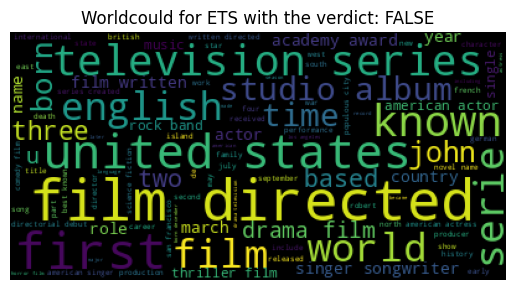

In [35]:
gerenate_worldcloud(fever_filtered, 'TRUE', 'claim')
gerenate_worldcloud(fever_filtered, 'TRUE', 'ETS')
gerenate_worldcloud(fever_filtered, 'FALSE', 'claim')
gerenate_worldcloud(fever_filtered, 'FALSE', 'ETS')

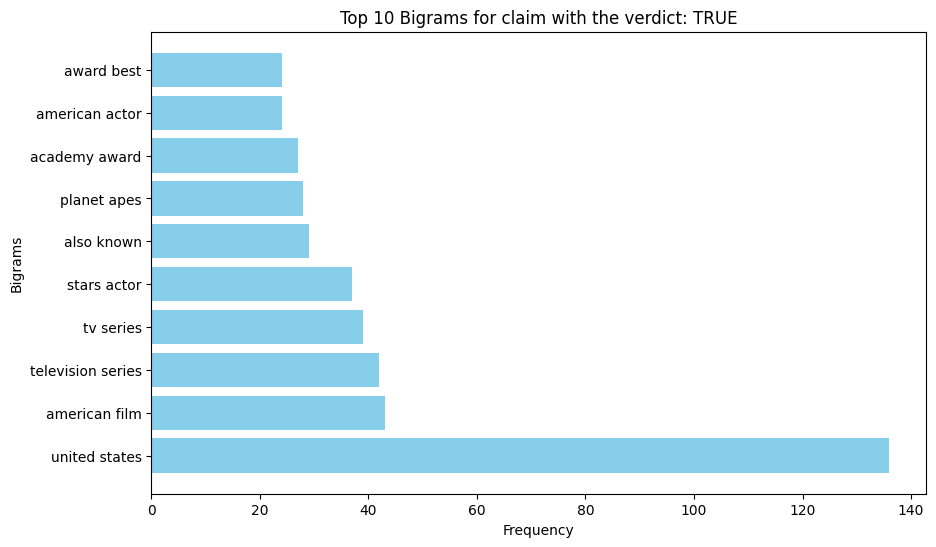

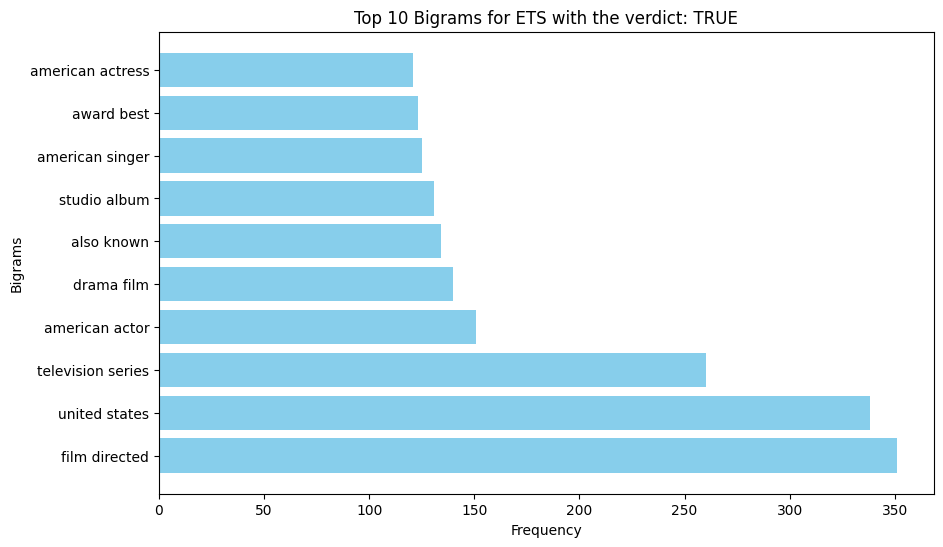

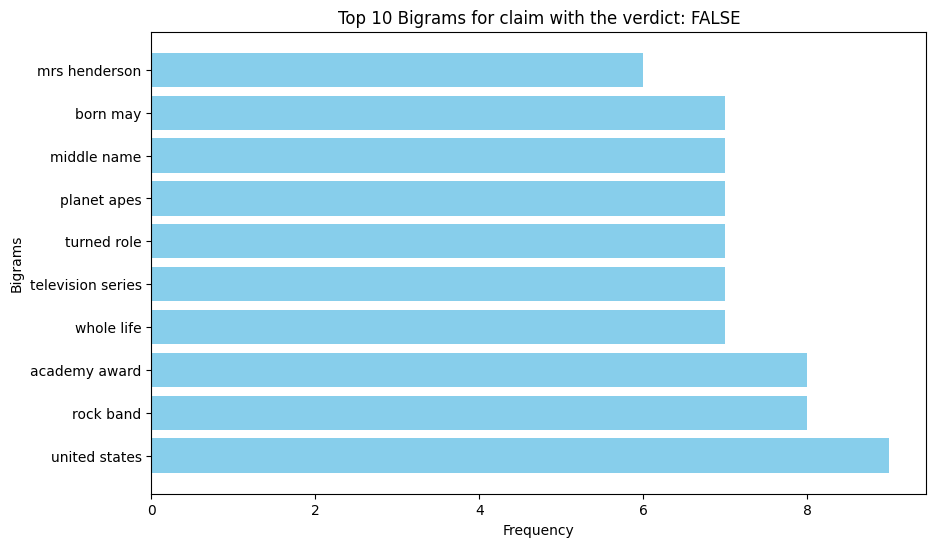

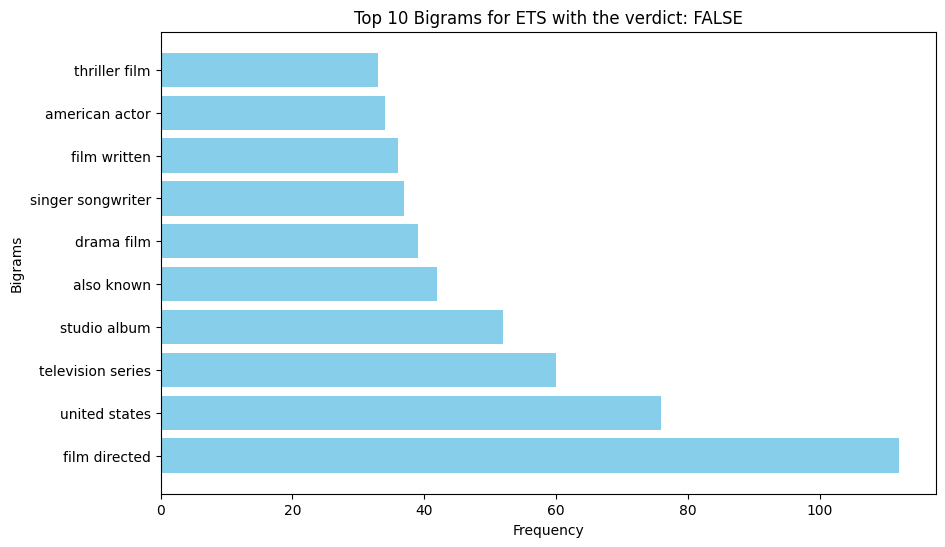

In [36]:
plot_top_bigram(fever_filtered, 'TRUE', 'claim', top_n=10)
plot_top_bigram(fever_filtered, 'TRUE', 'ETS', top_n=10)
plot_top_bigram(fever_filtered, 'FALSE', 'claim', top_n=10)
plot_top_bigram(fever_filtered, 'FALSE', 'ETS', top_n=10)

Both the top bigrams and WorldClouds shows that the FEVER corpus main topic is the american entertainment industry, mainly the cinema and music industy

# Snopes Corpus


## Exploration and preprocessing

In [37]:
snopes = pd.read_csv('drive/MyDrive/Colab Notebooks/TB/snopes_corpus_4.csv')

In [38]:
snopes

,ID,Snopes URL,Claim,Truthfulness (Verdicts),Snippets (ETS),Source URL,Source,Documents (orginal documents),Match ETS and Documents
0,1,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> The Marines patrolling through the green f...,http://archive.boston.com/news/world/asia/arti...,Marines learn lessons from tragedy in Afghanis...,Marines learn lessons from tragedy in Afghanis...,match
1,2,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> An infantryman from Camp Pendleton's 3rd B...,,,,
2,3,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> We are asking everyone to say a prayer for...,,,,
3,4,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> U.S. Marines who recently inherited this l...,,,,
4,5,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,,https://web.archive.org/web/20081004102646/htt...,3rd Battalion 5th Marines History,"Starting in 1996, Alexa Internet has been dona...",
...,...,...,...,...,...,...,...,...,...
25773,25774,http://www.snopes.com/clinton-memorial-day-actor/,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>UNIFORMS FOR RETIRED PERSONNEL</p> <p>GENER...,,,,
25774,25775,http://www.snopes.com/clinton-memorial-day-actor/,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>Now this is even low for the Clintons. Usin...,,,,
25775,25776,http://www.snopes.com/clinton-memorial-day-actor/,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>4.1.2. A member of the Armed Forces on acti...,,,,
25776,25777,http://www.snopes.com/clinton-memorial-day-actor/,Hillary Clinton paid an actor to dress up in N...,FALSE,,http://www.dodlive.mil/2012/07/24/election-sea...,"Election Season Calls For Caution, Professiona...","Election Season Calls For Caution, Professiona...",


In [39]:
print(snopes.columns)
print(snopes.isnull().any())
print(snopes.shape)

Index(['ID', 'Snopes URL', 'Claim', 'Truthfulness (Verdicts)',
       'Snippets (ETS)', 'Source URL', 'Source',
       'Documents (orginal documents)', 'Match ETS and Documents '],
      dtype='object')
ID                               False
Snopes URL                       False
Claim                             True
Truthfulness (Verdicts)           True
Snippets (ETS)                   False
Source URL                       False
Source                            True
Documents (orginal documents)    False
Match ETS and Documents          False
dtype: bool
(25778, 9)


In [40]:
snopes = snopes.dropna()

In [41]:
print(snopes.isnull().any())
print(snopes.shape)

ID                               False
Snopes URL                       False
Claim                            False
Truthfulness (Verdicts)          False
Snippets (ETS)                   False
Source URL                       False
Source                           False
Documents (orginal documents)    False
Match ETS and Documents          False
dtype: bool
(25702, 9)


First let's drop the column that will not be used and rename those we will

In [42]:
columns_to_drop = ['ID', 'Snopes URL', 'Source URL', 'Match ETS and Documents ', 'Source', 'Documents (orginal documents)']
snopes.drop(columns_to_drop, axis=1, inplace=True)

<ipython-input-42-f781a6349297>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snopes.drop(columns_to_drop, axis=1, inplace=True)


In [43]:
snopes.rename(columns={
    'Truthfulness (Verdicts)': 'label',
    'Snippets (ETS)': 'ETS',
    'Claim': 'claim'
}, inplace=True)

<ipython-input-43-236d8625eba8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snopes.rename(columns={


In [44]:
snopes.head()

,claim,label,ETS
0,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> The Marines patrolling through the green f...
1,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> An infantryman from Camp Pendleton's 3rd B...
2,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> We are asking everyone to say a prayer for...
3,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> U.S. Marines who recently inherited this l...
4,Prayers are requested for the Darkhorse Marine...,OUTDATED,


Compared to FEVER, Snopes has a lot more of different labels but only "Fake" and "True" are relevant. Let's see the other ones :

In [45]:
print(snopes['label'].value_counts().to_string())

FALSE                                                            11394
MIXTURE                                                           3548
TRUE                                                              2311
MOSTLY FALSE                                                      2129
UNPROVEN                                                          1839
 False                                                             989
 True                                                              634
MOSTLY TRUE                                                        537
LEGEND                                                             430
UNDETERMINED                                                       244
 Undetermined                                                      185
OUTDATED                                                           180
MIXTURE OF TRUE AND FALSE INFORMATION                              174
 Multiple                                                          163
MISCAP

In [46]:
print(snopes['label'].nunique())

83


In [47]:
snopes = snopes[snopes['label'].isin(['FALSE', 'TRUE', 'MOSTLY FALSE', 'MOSTLY TRUE'])]

snopes.head()

,claim,label,ETS
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic..."
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th..."
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...


Even if the corpus was hand-crafted, let's check if any ETS has issues

In [48]:
snopes['ETS_length'] = snopes['ETS'].apply(lambda x: len(str(x)))
sorted_snopes = snopes.sort_values(by='ETS_length', ascending=True)

print('10 shortest ETS :')
print(sorted_snopes.head(10)[['ETS_length', 'ETS']])

10 shortest ETS :
       ETS_length ETS
25777           1    
17860           1    
17861           1    
17863           1    
8031            1    
8030            1    
8029            1    
8028            1    
17864           1    
8025            1    


<ipython-input-48-117a8f27808e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snopes['ETS_length'] = snopes['ETS'].apply(lambda x: len(str(x)))


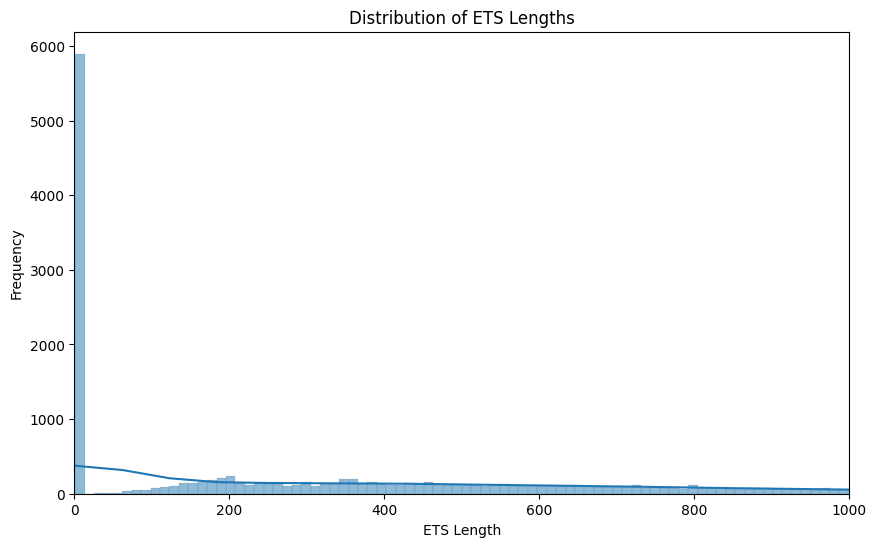

In [49]:
# Plot the distribution of ETS lengths
plt.figure(figsize=(10, 6))
sns.histplot(snopes['ETS_length'], bins=1000, kde=True)
plt.title('Distribution of ETS Lengths')
plt.xlabel('ETS Length')
plt.ylabel('Frequency')

plt.xlim(0, 1000)

plt.show()

It seems that a lot of ETS are empty or extremly short. Let's delete the rows where it is the case

In [50]:
snopes = snopes[snopes['ETS_length'] > 5]

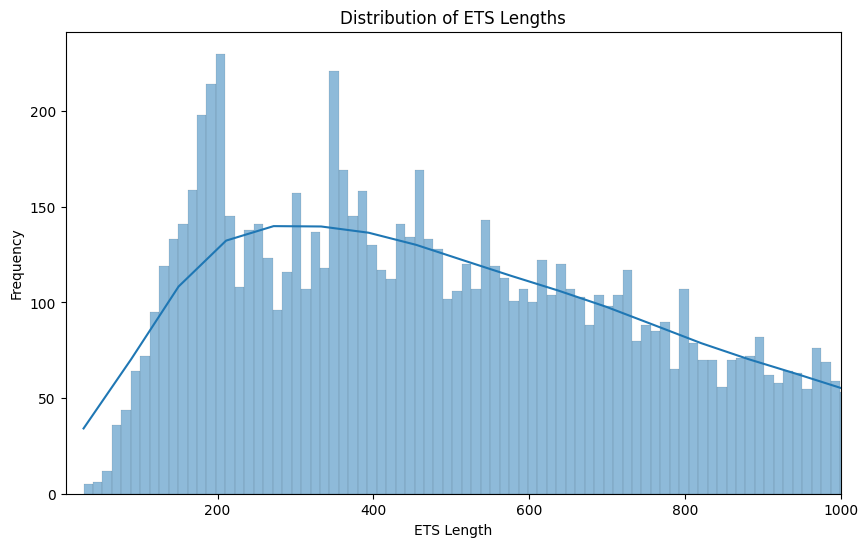

In [51]:
# Plot the distribution of ETS lengths
plt.figure(figsize=(10, 6))
sns.histplot(snopes['ETS_length'], bins=1000, kde=True)
plt.title('Distribution of ETS Lengths')
plt.xlabel('ETS Length')
plt.ylabel('Frequency')

plt.xlim(5, 1000)

plt.show()

Now it looks much better

In [52]:
snopes['label'].value_counts(normalize=True)

FALSE           0.685281
TRUE            0.156071
MOSTLY FALSE    0.128675
MOSTLY TRUE     0.029973
Name: label, dtype: float64

Because FEVER has only two labels (FALSE and TRUE). Let's convert MOSTLY TRUE into TRUE and MOSTLY FALSE into FALSE. Let's also add numerical_label and drop the ETS_length columns that won't be used anymore:

In [53]:
snopes['label'] = snopes['label'].replace({"MOSTLY FALSE": "FALSE", "MOSTLY TRUE": "TRUE"})
snopes['numerical_label'] = snopes['label'].map({"FALSE": 0, "TRUE": 1})
snopes = snopes.drop(columns='ETS_length')

In [54]:
snopes.head()

,claim,label,ETS,numerical_label
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic...",0
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...,0
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...,0
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th...",0
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...,0


In [55]:
print(snopes['label'].value_counts(normalize=False))

FALSE    8527
TRUE     1949
Name: label, dtype: int64


In [56]:
print(snopes['label'].value_counts(normalize=True))
print(fever['label'].value_counts(normalize=True))

FALSE    0.813956
TRUE     0.186044
Name: label, dtype: float64
TRUE     0.81598
FALSE    0.18402
Name: label, dtype: float64


Snopes corpus is unbalenced in favour of FALSE, which is the opposite of FEVER which was unbalenced in favour of TRUE. By putting them together later, they could balance each other out and create a belanced corpus

In [57]:
columns_to_process = ['ETS', 'claim']

# Use concurrent.futures to run the process in parallel
with concurrent.futures.ThreadPoolExecutor() as executor_snopes1:
    # Submit the tasks for each column
    futures = [executor_snopes1.submit(apply_preprocessing_with_progress, snopes ,column_name, stopwords=False, punctuation=False) for column_name in columns_to_process]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

In [58]:
snopes.head(100)

,claim,label,ETS,numerical_label
11,glen eagles hospital issued an urgent warning ...,FALSE,"recently, an email and short message service (...",0
12,glen eagles hospital issued an urgent warning ...,FALSE,i can 100% confirm that the text message going...,0
13,glen eagles hospital issued an urgent warning ...,FALSE,gleneagles hospital kuala lumpur has refuted a...,0
14,a tornado carried a mobile home for 130 miles ...,FALSE,"a family from tulsa, oklahoma, underwent the s...",0
15,a tornado carried a mobile home for 130 miles ...,FALSE,wndr assumes however all responsibility for th...,0
...,...,...,...,...
260,the supreme court ordered the smithsonian inst...,FALSE,a us supreme court ruling has forced the smit...,0
264,a woman was arrested after police discovered s...,FALSE,an 85-year old texas woman has been arrested ...,0
266,a daughter expressed her not-so-warm feelings ...,TRUE,"katherine reddick, 57, said she wrote the obi...",1
267,a daughter expressed her not-so-warm feelings ...,TRUE,"marianne theresa johnson-reddick born jan 4, ...",1


## WordCloud & TopBigrams

In [59]:
snopes_filtered = snopes.copy()

In [60]:
columns_to_process = ['ETS', 'claim']

# Use concurrent.futures to run the process in parallel
with concurrent.futures.ThreadPoolExecutor() as executor_snopes2:
    # Submit the tasks for each column
    futures = [executor_snopes2.submit(apply_preprocessing_with_progress, snopes_filtered ,column_name, stopwords=True) for column_name in columns_to_process]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

In [61]:
fever_filtered

,label,claim,numerical_label,ETS
0,TRUE,gianluigi buffon award goalkeeping,1,first ever goalkeeper win golden foot award al...
1,TRUE,colin farrell starred minority report,1,farrell began acting bbc drama series ballykis...
3,TRUE,reg watson created neighbours,1,reginald james watson 27 august 1926 – 8 octob...
5,TRUE,tiger woods tournament,1,end april 1997 three pga tour events addition ...
7,TRUE,nicki minaj grammy,1,outside music film television career included ...
...,...,...,...,...
10778,FALSE,frank ocean released concert album,0,ocean selfreleased second studio album blonde ...
10779,FALSE,darius rucker back vocalist hootie blowfish,0,first gained fame lead vocalist rhythm guitari...
10780,FALSE,curse inc ever used game kirby air ride,0,expanded company began develop acquire gaming ...
10781,FALSE,olympic games nearly 400 kittens,0,ancient olympics ancient olympic games ancient...


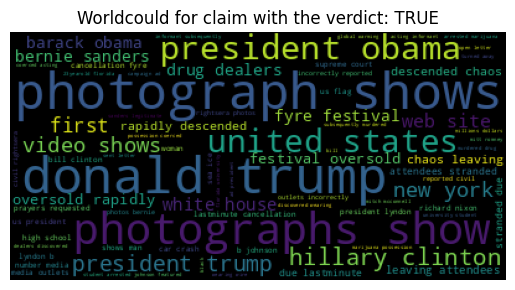

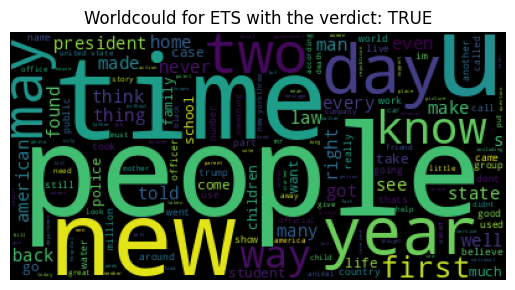

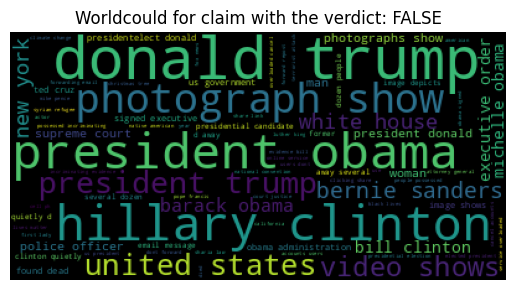

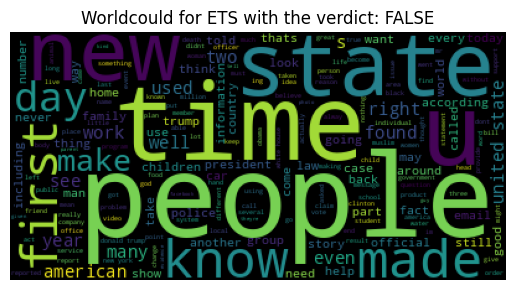

In [62]:
gerenate_worldcloud(snopes_filtered, 'TRUE', 'claim')
gerenate_worldcloud(snopes_filtered, 'TRUE', 'ETS')
gerenate_worldcloud(snopes_filtered, 'FALSE', 'claim')
gerenate_worldcloud(snopes_filtered, 'FALSE', 'ETS')

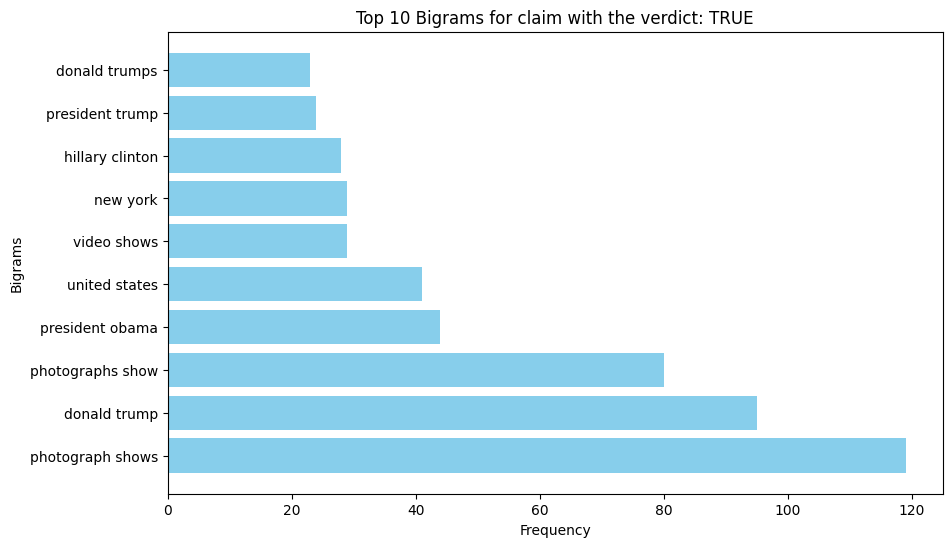

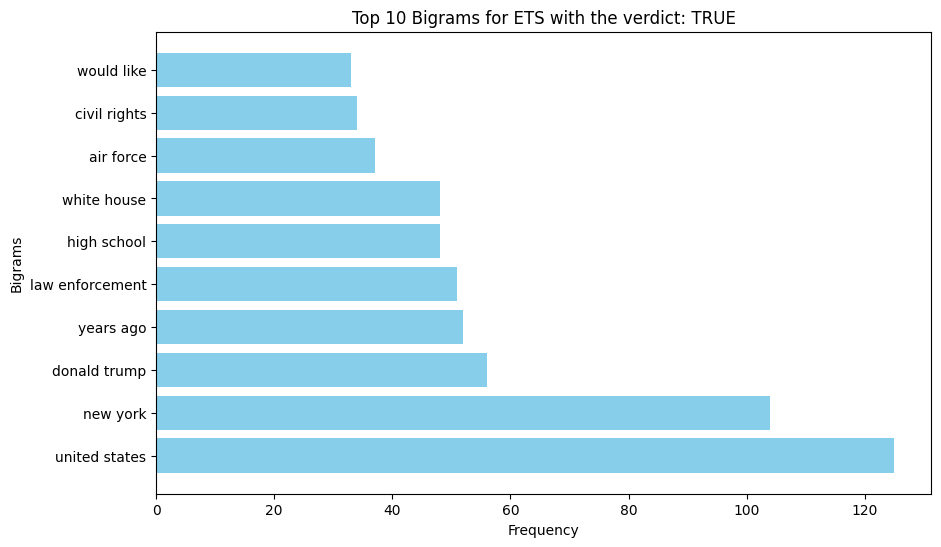

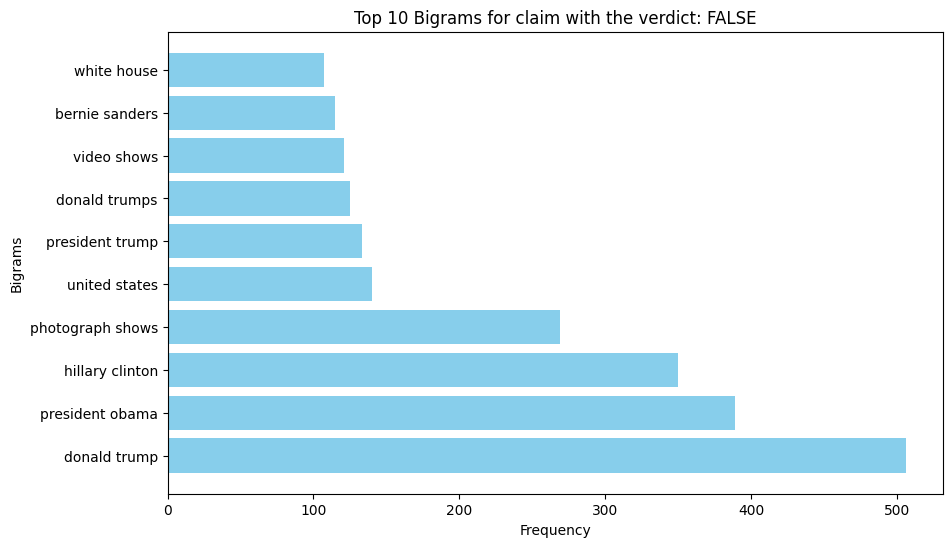

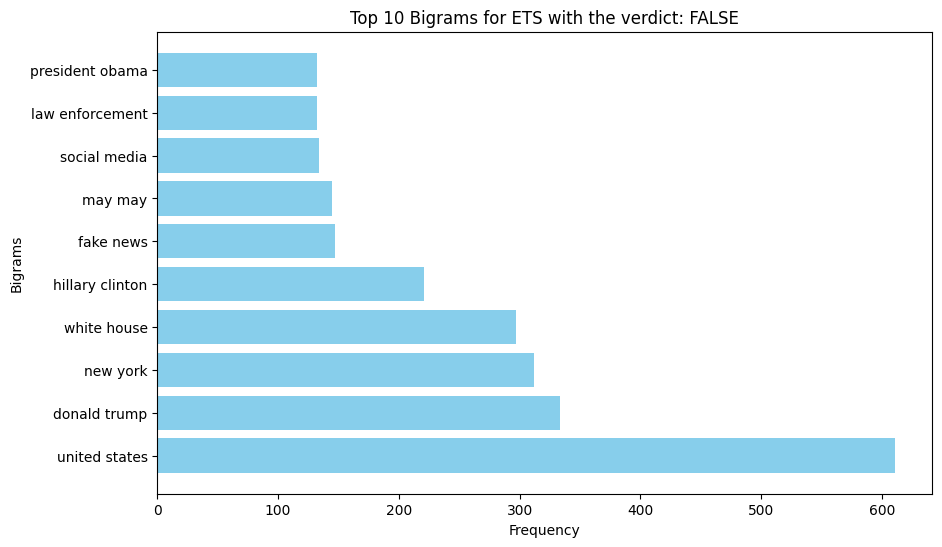

In [63]:
plot_top_bigram(snopes_filtered, 'TRUE', 'claim', top_n=10)
plot_top_bigram(snopes_filtered, 'TRUE', 'ETS', top_n=10)
plot_top_bigram(snopes_filtered, 'FALSE', 'claim', top_n=10)
plot_top_bigram(snopes_filtered, 'FALSE', 'ETS', top_n=10)

Both the top bigrams and the WorldCloud show that the Snopes corpus is mainly about american politics, espeically the 2016 elections with Trum and Clinton.

# Our Corpus

With the data exploration done on the Fever and the Snopes Corpus. It has been shown that both main claims and ETS are about the USA, the former focusing on the entraintenment world and the latter on the political world.

Both also have unbalenced data which can actually be balanced if put together. This will create a new balenced corpus with a focus on the USA.

In [64]:
corpus = pd.concat([fever, snopes], axis=0, ignore_index=True)

In [65]:
corpus

,label,claim,numerical_label,ETS
0,TRUE,gianluigi buffon won an award for goalkeeping.,1,he was the first ever goalkeeper to win the g...
1,TRUE,colin farrell starred in minority report.,1,farrell began acting in the bbc drama series b...
2,TRUE,reg watson created neighbours.,1,reginald james watson (27 august 1926 – 8 oct...
3,TRUE,tiger woods won a tournament.,1,"by the end of april 1997, he had won three pg..."
4,TRUE,nicki minaj has not won a grammy.,1,"outside of music, her film and television car..."
...,...,...,...,...
19432,FALSE,hillary clinton paid an actor to dress up in n...,0,enlisted surface warfare specialist navy/marin...
19433,FALSE,hillary clinton paid an actor to dress up in n...,0,"“oscar without the navy, is like me without a ..."
19434,FALSE,hillary clinton paid an actor to dress up in n...,0,uniforms for retired personnel general. retire...
19435,FALSE,hillary clinton paid an actor to dress up in n...,0,now this is even low for the clintons. using a...


In [66]:
print(snopes.columns)
print(snopes.isnull().any())
print(snopes.shape)

Index(['claim', 'label', 'ETS', 'numerical_label'], dtype='object')
claim              False
label              False
ETS                False
numerical_label    False
dtype: bool
(10476, 4)


Since the corpus is made of two preprocessed corpus there should be no need to process it, only its exploration is relevant.

## Exploration

In [67]:
print(corpus['label'].value_counts())
print(corpus['label'].value_counts(normalize=True))

FALSE    10176
TRUE      9261
Name: label, dtype: int64
FALSE    0.523538
TRUE     0.476462
Name: label, dtype: float64


In [68]:
print(fever['label'].value_counts())

TRUE     7312
FALSE    1649
Name: label, dtype: int64


<Axes: title={'center': 'Normalized distribution of labels (FEVER)'}>

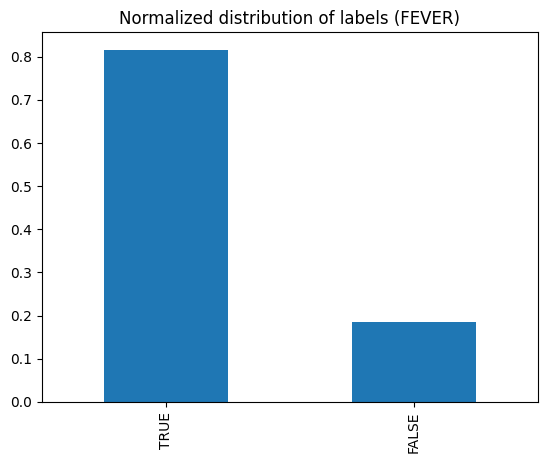

In [69]:
fever['label'].value_counts(normalize=True).plot(kind='bar', title='Normalized distribution of labels (FEVER)')

<Axes: title={'center': 'Normalized distribution of labels (SNOPES)'}>

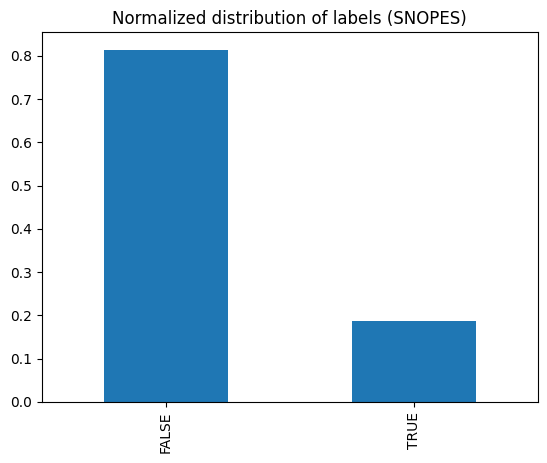

In [70]:
snopes['label'].value_counts(normalize=True).plot(kind='bar', title='Normalized distribution of labels (SNOPES)')

<Axes: title={'center': 'Normalized distribution of labels (FEVER + SNOPES)'}>

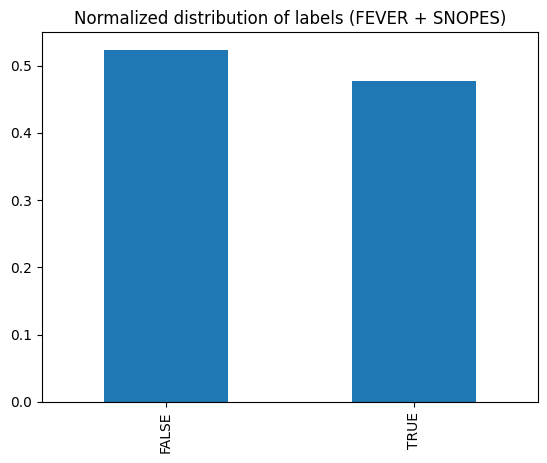

In [71]:
corpus['label'].value_counts(normalize=True).plot(kind='bar', title='Normalized distribution of labels (FEVER + SNOPES)')

The concatened corpus is much more balenced !

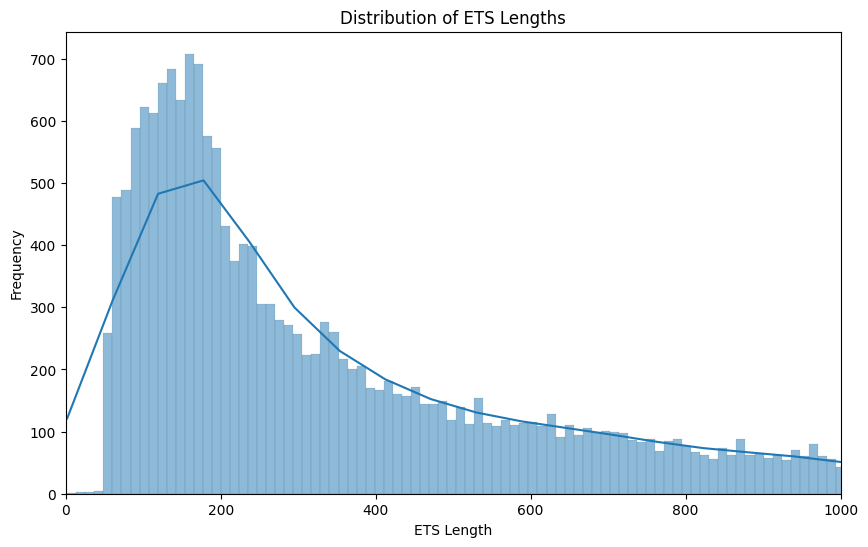

In [72]:
corpus['ETS_length'] = corpus['ETS'].apply(lambda x: len(str(x)))

plt.figure(figsize=(10, 6))
sns.histplot(corpus['ETS_length'], bins=1000, kde=True)
plt.title('Distribution of ETS Lengths')
plt.xlabel('ETS Length')
plt.ylabel('Frequency')

plt.xlim(0, 1000)

plt.show()

<Axes: title={'center': 'Average string length of labels'}, xlabel='label'>

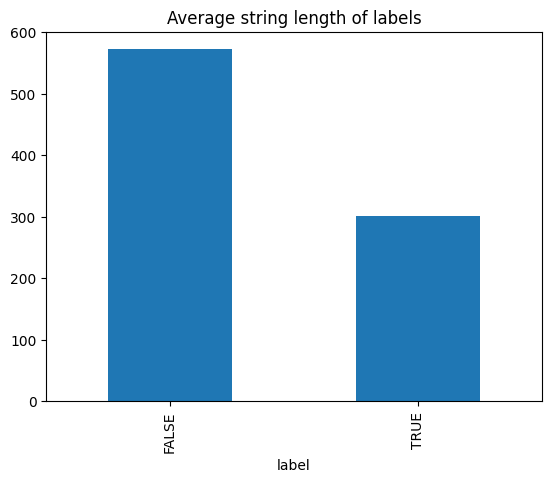

In [73]:
average_text_length_by_label = corpus.groupby('label')['ETS_length'].mean()
average_text_length_by_label.plot(kind='bar', title='Average string length of labels')

In [74]:
corpus = corpus.drop(columns='ETS_length')

## WordCloud & TopBigrams

In [75]:
corpus_filtered = corpus.copy()

In [76]:
columns_to_process = ['ETS', 'claim']

# Use concurrent.futures to run the process in parallel
with concurrent.futures.ThreadPoolExecutor() as executor_corpus:
    # Submit the tasks for each column
    futures = [executor_corpus.submit(apply_preprocessing_with_progress, corpus_filtered ,column_name, stopwords=True) for column_name in columns_to_process]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

In [77]:
corpus_filtered

,label,claim,numerical_label,ETS
0,TRUE,gianluigi buffon award goalkeeping,1,first ever goalkeeper win golden foot award al...
1,TRUE,colin farrell starred minority report,1,farrell began acting bbc drama series ballykis...
2,TRUE,reg watson created neighbours,1,reginald james watson 27 august 1926 – 8 octob...
3,TRUE,tiger woods tournament,1,end april 1997 three pga tour events addition ...
4,TRUE,nicki minaj grammy,1,outside music film television career included ...
...,...,...,...,...
19432,FALSE,hillary clinton paid actor dress navy attire m...,0,enlisted surface warfare specialist navymarine...
19433,FALSE,hillary clinton paid actor dress navy attire m...,0,“ oscar without navy like without pants suit ”...
19434,FALSE,hillary clinton paid actor dress navy attire m...,0,uniforms retired personnel general retired off...
19435,FALSE,hillary clinton paid actor dress navy attire m...,0,even low clintons using actor memorial day par...


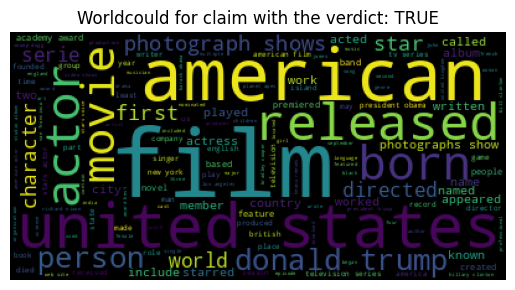

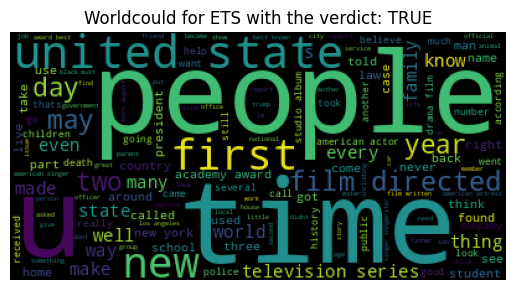

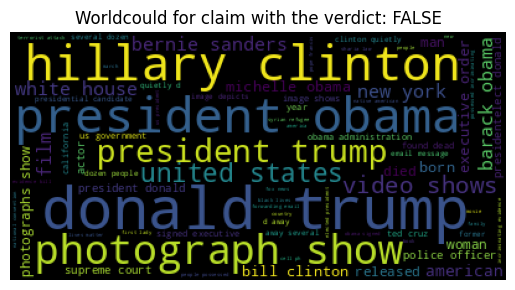

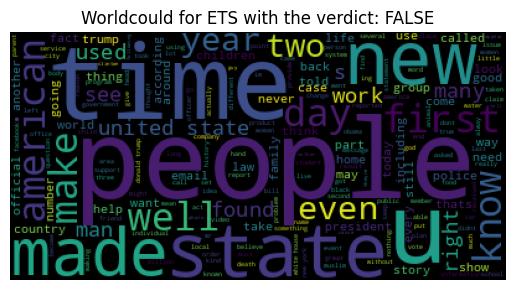

In [78]:
gerenate_worldcloud(corpus_filtered, 'TRUE', 'claim')
gerenate_worldcloud(corpus_filtered, 'TRUE', 'ETS')
gerenate_worldcloud(corpus_filtered, 'FALSE', 'claim')
gerenate_worldcloud(corpus_filtered, 'FALSE', 'ETS')

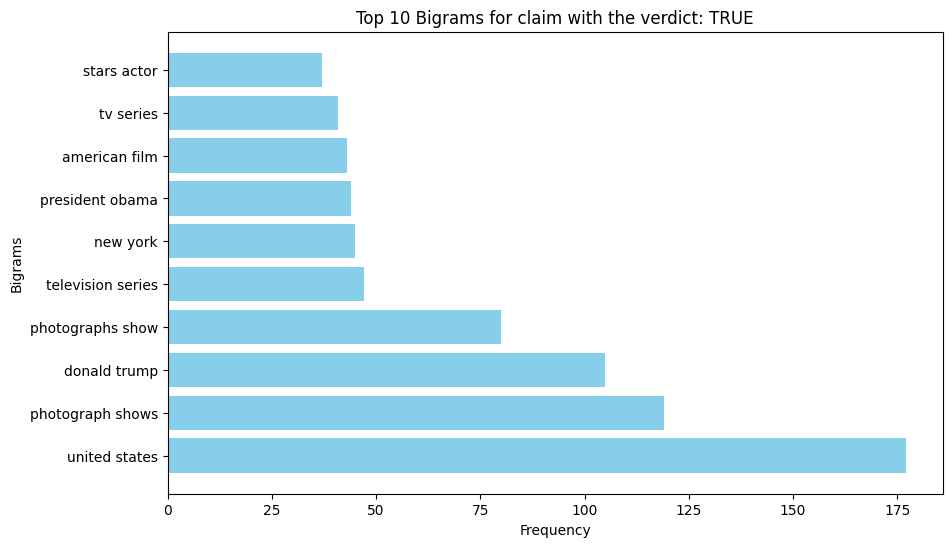

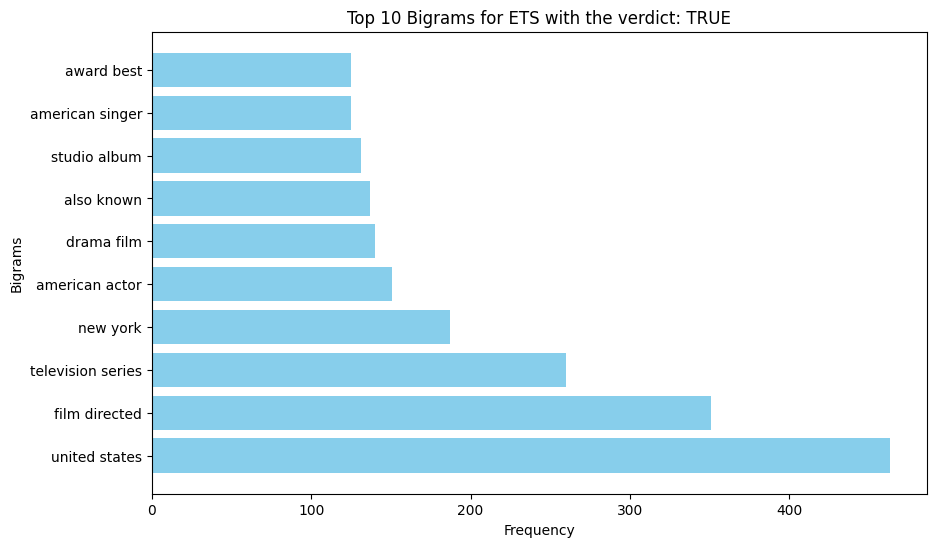

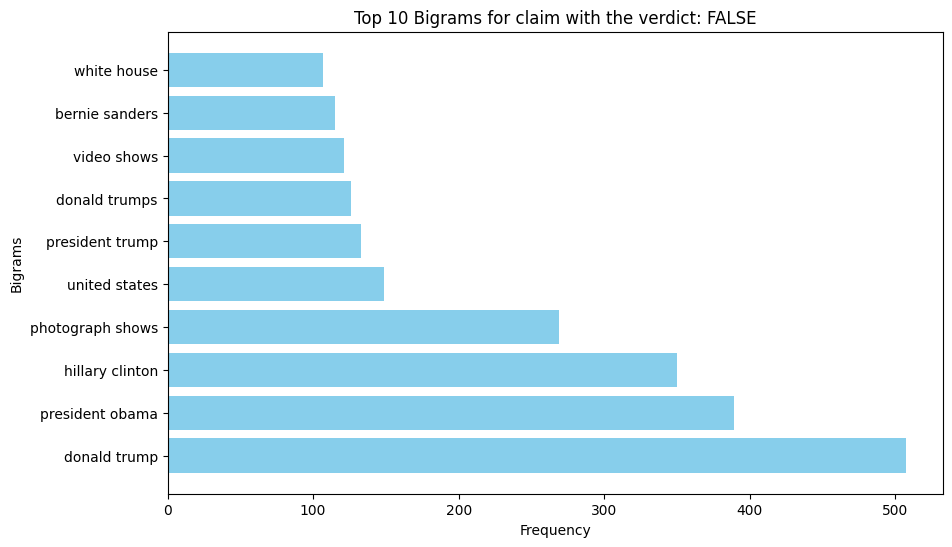

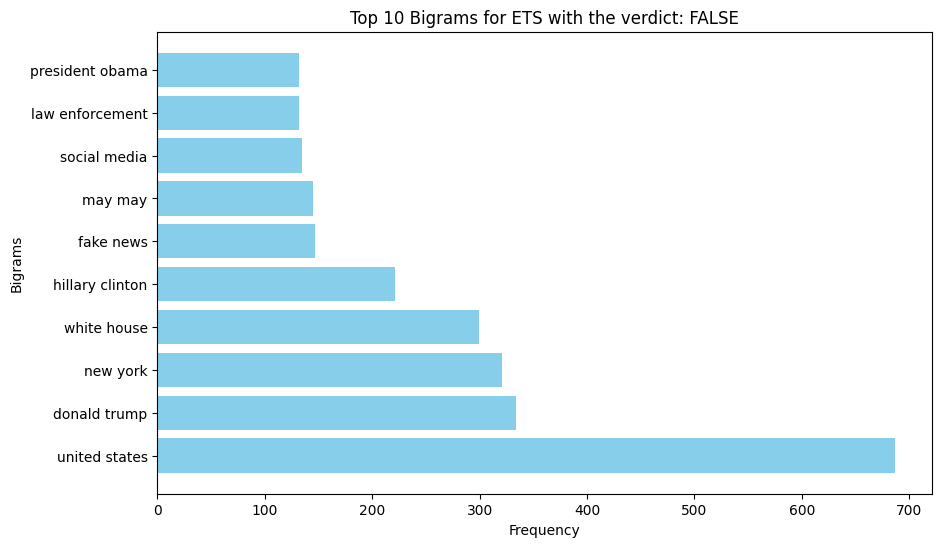

In [79]:
plot_top_bigram(corpus_filtered, 'TRUE', 'claim', top_n=10)
plot_top_bigram(corpus_filtered, 'TRUE', 'ETS', top_n=10)
plot_top_bigram(corpus_filtered, 'FALSE', 'claim', top_n=10)
plot_top_bigram(corpus_filtered, 'FALSE', 'ETS', top_n=10)

As excpected, the concatened corpus is about the USA

# Bert Tokenizer

In [80]:
df = corpus.copy()

In [81]:
df.head()

,label,claim,numerical_label,ETS
0,TRUE,gianluigi buffon won an award for goalkeeping.,1,he was the first ever goalkeeper to win the g...
1,TRUE,colin farrell starred in minority report.,1,farrell began acting in the bbc drama series b...
2,TRUE,reg watson created neighbours.,1,reginald james watson (27 august 1926 – 8 oct...
3,TRUE,tiger woods won a tournament.,1,"by the end of april 1997, he had won three pg..."
4,TRUE,nicki minaj has not won a grammy.,1,"outside of music, her film and television car..."


### Tokenizer & Example

In [82]:
def tokenize_column(df, column_name, tokenizer):
    # Convert the column to a list
    column_texts = df[column_name].tolist()

    # Tokenize each text
    tokenized_data = [tokenizer(text, truncation=True, padding='max_length', return_tensors = 'tf') for text in column_texts]

    # Add the tokenized data to the DataFrame
    df[column_name + '_tokenized'] = tokenized_data
    return df

In [83]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = tokenize_column(df, 'ETS', tokenizer)
df = tokenize_column(df, 'claim', tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [84]:
df

,label,claim,numerical_label,ETS,ETS_tokenized,claim_tokenized
0,TRUE,gianluigi buffon won an award for goalkeeping.,1,he was the first ever goalkeeper to win the g...,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
1,TRUE,colin farrell starred in minority report.,1,farrell began acting in the bbc drama series b...,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
2,TRUE,reg watson created neighbours.,1,reginald james watson (27 august 1926 – 8 oct...,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
3,TRUE,tiger woods won a tournament.,1,"by the end of april 1997, he had won three pg...","[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
4,TRUE,nicki minaj has not won a grammy.,1,"outside of music, her film and television car...","[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
...,...,...,...,...,...,...
19432,FALSE,hillary clinton paid an actor to dress up in n...,0,enlisted surface warfare specialist navy/marin...,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
19433,FALSE,hillary clinton paid an actor to dress up in n...,0,"“oscar without the navy, is like me without a ...","[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
19434,FALSE,hillary clinton paid an actor to dress up in n...,0,uniforms for retired personnel general. retire...,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
19435,FALSE,hillary clinton paid an actor to dress up in n...,0,now this is even low for the clintons. using a...,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


Example of tokenization :**TO CLEAN**

In [139]:
vocab = tokenizer.vocab
print(f"Length of the vocabulary: {len(vocab)}")
print("Tokenized sequence: 'hello world 🙂 !'")
print(tokenizer(['hello world 🙂 !']))
print(f"Index of 'hello': {vocab['hello']}")
print(f"Index of 'world': {vocab['world']}")
try:
  print(f"Index of '🙂': {vocab['🙂']}")
except Exception as e :
  print(f"No index found for:{e}")
print(f"Index of '!': {vocab['!']}")

print(f"Word at index 100: {tokenizer.convert_ids_to_tokens(100)}")
print(f"Word at index 101: {tokenizer.convert_ids_to_tokens(101)}")
print(f"Word at index 102: {tokenizer.convert_ids_to_tokens(102)}")

Length of the vocabulary: 30522
Tokenized sequence: 'hello world 🙂 !'
{'input_ids': [[101, 7592, 2088, 100, 999, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1]]}
Index of 'hello': 7592
Index of 'world': 2088
No index found for:'🙂'
Index of '!': 999
Word at index 100: [UNK]
Word at index 101: [CLS]
Word at index 102: [SEP]


Example of a word broken down into subwords units

In [142]:
print("Tokenized sequence 'Classifier'")
print(tokenizer(["Classifier"]))
print(f"Word at index 2465: {tokenizer.convert_ids_to_tokens(2465)}")
print(f"Word at index 18095: {tokenizer.convert_ids_to_tokens(18095)}")

Tokenized sequence 'Classifier'
{'input_ids': [[101, 2465, 18095, 102]], 'token_type_ids': [[0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1]]}
Word at index 2465: class
Word at index 18095: ##ifier


### Exploring the tokenized dataset

In [85]:
columns_to_print = ['claim', 'claim_tokenized', 'ETS', 'ETS_tokenized']

for column in columns_to_print:
    # Get the data for the column
    data = df[column].iloc[0]

    if isinstance(data, str):
      print(f'Column: {column}')
      print(f'Untokenized text ({len(data)}): {data}')
    else:
      # Get the input_ids, token_type_ids, and attention_mask
      input_ids = data['input_ids'][0]
      token_type_ids = data['token_type_ids'][0]
      attention_mask = data['attention_mask'][0]

      # Print the input_ids, token_type_ids, and attention_mask
      print(f'Column: {column}')
      print(f'Input IDs ({len(input_ids)}): {input_ids}')
      print(f'Token Type IDs ({len(token_type_ids)}): {token_type_ids}') #in BERT, all tokens are treated as regular world so only we only have 0's
      print(f'Attention Mask ({len(attention_mask)}): {attention_mask}') # 1 if a regular word, 0 if it is padding
      print('================')


Column: claim
Untokenized text (46): gianluigi buffon won an award for goalkeeping.
Column: claim_tokenized
Input IDs (512): [  101 27699 20554 10179  5856 23176  2239  2180  2019  2400  2005  3125
 18321  1012   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0

In [ ]:
ex = df['claim_tokenized'].iloc[0]['input_ids'][0]
print(f'Type of {ex} is ---> {type(ex)} ')

In [ ]:
df_tokenized = df.copy()

In [ ]:
df_tokenized.drop('claim', axis=1, inplace=True)
df_tokenized.drop('label', axis=1, inplace=True)
df_tokenized.drop('ETS', axis=1, inplace=True)

In [ ]:
df_tokenized

In [ ]:
print(df_tokenized['numerical_label'].value_counts(normalize=False))
print(df_tokenized['numerical_label'].value_counts(normalize=True))

# Building the BERT Models


![BERT Classifier](https://drive.google.com/uc?export=view&id=1Vs1h_SHk3P1gG6SP9Wsw2vHgmCTPZZ9-)

## SimpleBERTClassifer (one input, Claims or ETS)

In [ ]:
class SimpleBertClassifier(tf.keras.Model):
    def __init__(self, num_labels, max_length=128):
        super(SimpleBertClassifier, self).__init__()

        # BERT model layers
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

        # Input layers
        self.input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="input_ids")
        self.attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="attention_mask")

        # Dense layers for classification
        self.dense1 = Dense(128, activation='relu')
        self.output_layer = Dense(num_labels, activation='softmax')

    def call(self, inputs, training=False):
        # Extract inputs
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # BERT forward pass
        print(f"Input IDs shape: {input_ids.shape}")
        print(f"Attention Mask shape: {attention_mask.shape}")

        bert_outputs = self.bert_model(input_ids, attention_mask=attention_mask)

        print(f"Bert Outputs keys: {bert_outputs.keys()}")
        pooled_output = bert_outputs.pooler_output

        # Dense layers for classification
        print(f"Pooled Output shape: {pooled_output.shape}")
        dense1_output = self.dense1(pooled_output)
        output = self.output_layer(dense1_output)

        print(f"Output shape: {output.shape}")
        return output

In [ ]:
model_claim = SimpleBertClassifier(num_labels=6, max_length=512)
model_ets = SimpleBertClassifier(num_labels=6, max_length=512)

In [ ]:
model_claim.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_ets.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Dummy data for building the model
dummy_data = {
    'input_ids': tf.ones((1, 512), dtype=tf.int32),
    'attention_mask': tf.ones((1, 512), dtype=tf.int32)
}

# Call the model on the dummy data to build it
_ = model_claim(dummy_data)
_ = model_ets(dummy_data)


model_claim.summary()
model_ets.summary()

## DoubleBERTClassifer (two inputs, Claim and ETS)

This model is able to be trained with both Claims and ETS or only with Claims. This is because it is able to predict the label of a claim without any ETS inputs as, when delivered, users will only inputs claims. Thanks to this, the model should also be benefiting from the ETS data when a user use it !

In [ ]:
class DoubleBertClassifier(tf.keras.Model):
    def __init__(self, num_labels, max_length=128):
        super(DoubleBertClassifier, self).__init__()

        # BERT model layers
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

        # Input layers for claim
        self.claim_input_ids = Input(shape=(max_length,), dtype=tf.int32, name="claim_input_ids")
        self.claim_attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="claim_attention_mask")

        # Input layers for ETS
        self.ets_input_ids = Input(shape=(max_length,), dtype=tf.int32, name="ets_input_ids")
        self.ets_attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="ets_attention_mask")

        # Dense layers for classification
        self.dense1 = Dense(128, activation='relu')
        self.output_layer = Dense(num_labels, activation='softmax')

    def call(self, inputs, training=False):
        # Check if ETS data is provided
        if 'ets_input_ids' in inputs and 'ets_attention_mask' in inputs:
            # Concatenate claim and ETS for prediction
            concatenated_input_ids = tf.concat([inputs['claim_input_ids'], inputs['ets_input_ids']], axis=1)
            concatenated_attention_mask = tf.concat([inputs['claim_attention_mask'], inputs['ets_attention_mask']], axis=1)
        else:
            # Use only claim data for prediction
            concatenated_input_ids = inputs['claim_input_ids']
            concatenated_attention_mask = inputs['claim_attention_mask']

        # BERT forward pass
        bert_outputs = self.bert_model(concatenated_input_ids, attention_mask=concatenated_attention_mask)
        pooled_output = bert_outputs.pooler_output

        # Dense layers for classification
        dense1_output = self.dense1(pooled_output)
        output = self.output_layer(dense1_output)

        return output


In [ ]:
"""
OLD VERSION NOT ABLE TO PREDICT ONLY CLAIMS WHEN USER USE IT

class DoubleBertClassifier(tf.keras.Model):
    def __init__(self, num_labels, max_length=128):
        super(DoubleBertClassifier, self).__init__()

        # BERT model layers
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

        # Input layers for claim
        self.claim_input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="claim_input_ids")
        self.claim_attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="claim_attention_mask")

        # Input layers for ETS
        self.ets_input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="ets_input_ids")
        self.ets_attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="ets_attention_mask")

        # Dense layers for classification
        self.dense1 = Dense(128, activation='relu')
        self.output_layer = Dense(num_labels, activation='softmax')

    def call(self, inputs, training=False):
        # Extract inputs for claim
        claim_input_ids = inputs['claim_input_ids']
        claim_attention_mask = inputs['claim_attention_mask']

        # Extract inputs for ETS
        ets_input_ids = inputs['ets_input_ids']
        ets_attention_mask = inputs['ets_attention_mask']

        # Concate claim and ETS
        concatenated_input_ids = tf.concat([claim_input_ids, ets_input_ids], axis=1)
        concatenated_attention_mask = tf.concat([claim_attention_mask, ets_attention_mask], axis=1)

        # BERT forward pass
        bert_outputs = self.bert_model(concatenated_input_ids, attention_mask=concatenated_attention_mask)
        pooled_output = bert_outputs.pooler_output

        # Dense layers for classification
        dense1_output = self.dense1(pooled_output)
        output = self.output_layer(dense1_output)

        return output"""

In [ ]:
double_model = DoubleBertClassifier(num_labels=6, max_length=512)

In [ ]:
double_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Dummy data for building the model
dummy_data = {
    'claim_input_ids': tf.ones((1, 512), dtype=tf.int32),
    'claim_attention_mask': tf.ones((1, 512), dtype=tf.int32),
    'ets_input_ids': tf.ones((1, 512), dtype=tf.int32),
    'ets_attention_mask': tf.ones((1, 512), dtype=tf.int32)
}

# Call double_model model on the dummy data to build it
_ = double_model(dummy_data)

# Now you can print the model summary
double_model.summary()

# Splitting the dataset (Claim)

In [ ]:
X = pd.DataFrame({
    "claim_tokenized": df_tokenized["claim_tokenized"],
    "ETS_tokenized": df_tokenized["ETS_tokenized"]
})
y = df_tokenized["numerical_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X

In [ ]:
print(f'Shape of X:\n{X.shape}')
print(f'Shape of y:\n{y.shape}')
print()
print(f'Shape of X_train:\n{X_train.shape}')
print(f'Shape of y_train:\n{y_train.shape}')
print(f'Shape of X_test:\n{X_test.shape}')
print(f'Shape of y_test:\n{y_test.shape}')
print(f'Shape of X_val:\n{X_val.shape}')
print(f'Shape of y_test:\n{y_val.shape}')

Transform the tokenized data to the tensors (`tf.int32`) that BERT model requires

In [ ]:
def convert_to_tensor(df, token_type):
  converted_tensors = []
  for i in range(len(df)):
    data = df.iloc[i][token_type]
    converted_tensor = tf.convert_to_tensor(data, dtype=tf.int32)
    converted_tensors.append(converted_tensor)
  return tf.concat(converted_tensors, axis=0)

Because we will train both the Simple and Double BERT classifier, we need to separate Claim and ETS.

In [ ]:
# Convert tokenized sequences to tensors for training data
train_claim_input_ids = convert_to_tensor(X_train['claim_tokenized'], token_type='input_ids')
train_claim_attention_mask = convert_to_tensor(X_train['claim_tokenized'], token_type='attention_mask')

train_ets_input_ids = convert_to_tensor(X_train['ETS_tokenized'], token_type='input_ids')
train_ets_attention_mask = convert_to_tensor(X_train['ETS_tokenized'], token_type='attention_mask')

# Convert tokenized sequences to tensors for validation data
val_claim_input_ids = convert_to_tensor(X_val['claim_tokenized'], token_type='input_ids')
val_claim_attention_mask = convert_to_tensor(X_val['claim_tokenized'], token_type='attention_mask')

val_ets_input_ids = convert_to_tensor(X_val['ETS_tokenized'], token_type='input_ids')
val_ets_attention_mask = convert_to_tensor(X_val['ETS_tokenized'], token_type='attention_mask')

# Convert tokenized sequences to tensors for test data
test_claim_input_ids = convert_to_tensor(X_test['claim_tokenized'], token_type='input_ids')
test_claim_attention_mask = convert_to_tensor(X_test['claim_tokenized'], token_type='attention_mask')

test_ets_input_ids = convert_to_tensor(X_test['ETS_tokenized'], token_type='input_ids')
test_ets_attention_mask = convert_to_tensor(X_test['ETS_tokenized'], token_type='attention_mask')


### Shape annd Type of training data

In [ ]:
print(f'Shape and datatype of Claim Input IDs:\n{train_claim_input_ids.shape}\n{type(train_claim_input_ids)}\n')
print(f'Shape and datatype of Claim Attention Mask:\n{train_claim_attention_mask.shape}\n{type(train_claim_attention_mask)}\n')

print(f'Shape and datatype of ETS Input IDs:\n{train_ets_input_ids.shape}\n{type(train_ets_input_ids)}\n')
print(f'Shape and datatype of ETS Attention Mask:\n{train_ets_attention_mask.shape}\n{type(train_ets_attention_mask)}\n')

print(f'Shape and datatype of y_train:\n{y_train.shape}\n{type(y_train)}')

### Shape annd Type of validation data

In [ ]:
print(f'Shape and datatype of Claim Input IDs:\n{val_claim_input_ids.shape}\n{type(val_claim_input_ids)}\n')
print(f'Shape and datatype of Claim Attention Mask:\n{val_claim_attention_mask.shape}\n{type(val_claim_attention_mask)}\n')

print(f'Shape and datatype of ETS Input IDs:\n{val_ets_input_ids.shape}\n{type(val_ets_input_ids)}\n')
print(f'Shape and datatype of ETS Attention Mask:\n{val_ets_attention_mask.shape}\n{type(val_ets_attention_mask)}\n')

print(f'Shape and datatype of y_val:\n{y_val.shape}\n{type(y_val)}')

### Shape annd Type of test data

In [ ]:
print(f'Shape and datatype of Claim Input IDs:\n{test_claim_input_ids.shape}\n{type(test_claim_input_ids)}\n')
print(f'Shape and datatype of Claim Attention Mask:\n{test_claim_attention_mask.shape}\n{type(test_claim_attention_mask)}\n')

print(f'Shape and datatype of ETS Input IDs:\n{test_ets_input_ids.shape}\n{type(test_ets_input_ids)}\n')
print(f'Shape and datatype of ETS Attention Mask:\n{test_ets_attention_mask.shape}\n{type(test_ets_attention_mask)}\n')

print(f'Shape and datatype of y_test:\n{y_test.shape}\n{type(y_test)}')

# Hyperparameters

In [ ]:
subset_size = 100
batch_size = 10
num_epochs = 6

# SimpleBERTClassifier (Claims)

### Training

RESULTS :

In [ ]:
model_claim.fit(
    {'input_ids': train_claim_input_ids, 'attention_mask': train_claim_attention_mask},
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
)

## Evaluate

RESULTS :

In [ ]:
evaluation = model_claim.evaluate({'input_ids': val_claim_input_ids, 'attention_mask': val_claim_input_ids},
                            y_val,
                            batch_size=batch_size) #TO DO: try without it, see what evaluate do exactly
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

## Prediction

RESULTS :

In [ ]:
# Using the model to make predictions on validation data
predictions = model_claim.predict({'input_ids': test_claim_input_ids, 'attention_mask': test_claim_attention_mask})
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print('Classification Report:')
print(classification_report(y_test, predicted_labels))

# Generate a confusion matrix
conf_mat = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:')
print(conf_mat)

In [ ]:
# Plot the confusion matrix with axis labels using seaborn
labels = list(verdict_mapping.keys())
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_claim.save("SimpleBERTClassifier_Claim", save_format="tf")

# SimpleBERTClassifier (ETS)

## Training

RESULTS :

In [ ]:
model_ets.fit(
    {'input_ids': train_ets_input_ids, 'attention_mask': train_ets_attention_mask},
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
)

~~Training accuracy and loss ~~

 ~~**With 3 epochs :**~~

~~Contrary to the model using only the Claims, it seems it is harder to train the model with only the ETS. The accuracy did increase quite a lot between the first and third epoch however, going from 50.58% to 72.32%. Increasing the number should therefore increase the accuracy~~

~~**With 6 epochs :**~~

~~As excpected, increasing the number of epochs did improve the accuracy and the loss consideratly. From the fourth epoch already we went from 78.29% to 91.73% ! On the fifth epoch we have loss of 0.1146 and an accuracy 96.57% (we had a similar result on the third epochs using only the Claims) **On the sixth and final epochs, we get an accuracy of 97.55% and a loss of 0.0816**~~

~~ETS being more diverse than claims (There can be the same claim many times in the dataset with different ETS), it makes sense that this version of the model took a longer time reach a decent accuracy and loss. It also means it should work better on a more wide range of new input data !~~

## Evaluate

RESULTS :

In [ ]:
evaluation = model_ets.evaluate({'input_ids': val_ets_input_ids, 'attention_mask': val_ets_attention_mask},
                            y_val,
                            batch_size=batch_size)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

~~Accuracy and loss on the validation set~~

~~**Results after 3 epochs :**~~

~~As expected with the training results, the accuracy is only 56.72% and the loss is quite high (1.2531) with the validation set so we definitly need to tune the hyperparameters before predicting the test set.~~

~~**Results after 6 epochs :**~~

~~Despite increasing the number of epochs and getting a much higher accuracy during training (97.55%) the accuracy for the validation set is still low (55.29%) and the loss (2.1803) is even higher than during the 3 epochs. Again, this could be because the ETS are more diverse than the Claims.~~

~~**Maybe it would be more interesting to do the evaluation on the Claims rather than the ETS as in practice the model is supposed to predict the credibility of a claim.**~~


## Prediction

RESULTS :


In [ ]:
# Using the model to make predictions on test data
predictions = model_ets.predict({'input_ids': test_claim_input_ids, 'attention_mask': test_claim_attention_mask})
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print('Classification Report:')
print(classification_report(y_test, predicted_labels))

# Generate a confusion matrix
conf_mat = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:')
print(conf_mat)

In [ ]:
# Plot the confusion matrix with axis labels using seaborn
labels = list(verdict_mapping.keys())
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_ets.save("SimpleBERTClassifier_ETS", save_format="tf")

# DoubleBERTClassifier (Claims & ETS)

## Training

RESULTS :

In [ ]:
double_model.fit(
    {'claim_input_ids': train_claim_input_ids,
    'claim_attention_mask': train_claim_attention_mask,
    'ets_input_ids': train_ets_input_ids,
    'ets_attention_mask': train_ets_attention_mask},
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
)

## Evaluate

RESULTS :

In [ ]:
evaluation = double_model.evaluate({'claim_input_ids': val_claim_input_ids,
                                  'claim_attention_mask': val_claim_attention_mask,
                                  'ets_input_ids': val_ets_input_ids,
                                  'ets_attention_mask': val_ets_attention_mask},
                            y_val,
                            batch_size=batch_size)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

## Prediction

RESULTS :

In [ ]:
# Using the model to make predictions on test data (only Claim as the user will do)
predictions = double_model.predict({'claim_input_ids': test_claim_input_ids,
                                  'claim_attention_mask': test_claim_attention_mask,})
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print('Classification Report:')
print(classification_report(y_test, predicted_labels))

# Generate a confusion matrix
conf_mat = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:')
print(conf_mat)

In [ ]:
# Plot the confusion matrix with axis labels using seaborn
labels = list(verdict_mapping.keys())
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
double_model.save("DoubleBERTClassifier", save_format="tf")

# Might use this later



loading a model

In [ ]:
loaded_model = tf.keras.models.load_model("my_BERTClassifier")

Sliding window for documents

In [ ]:
# Creates overlapping windows of tokenized text for a given input text using a sliding window approach.
# This is done because a lot of the text data exeeds the maximum lenght accepted by the tokenizer
def sliding_window(text, tokenizer, window_size=512, stride=256):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')['input_ids']
    total_length = tokens.size(1)

     # If the text is shorter than window_size, create a window without padding
    if total_length <= window_size:
        # Adjust the window_size to the actual length of the text
        windows = [tokens[:, :total_length]]
    else:
        # Create windows with the specified stride
        windows = [tokens[:, i:i+window_size] for i in range(0, total_length, stride) if i+window_size <= total_length]

    return windows

In [ ]:
# Function to process sliding windows for a dataset
def process_windows(df, data_windows, tokenizer, stride=256, window_size=512):
    pbar = tqdm(total=len(df), desc=f"Processing {df.name}", position=0, leave=False)
    for i, text in enumerate(df):
        try:
            windows = sliding_window(text, tokenizer, window_size, stride)
            data_windows.extend(windows)
            pbar.update()
        except Exception as e:
            print(f"An error occurred: {e}")
    pbar.close()

model training ober subsets

In [ ]:
subset_input_ids = train_input_ids[:subset_size]
subset_attention_mask = train_attention_mask[:subset_size]
subset_labels = y_train[:subset_size]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    for i in range(subset_size // batch_size):
        start = i * batch_size
        end = (i + 1) * batch_size

        subset_batch_input_ids = subset_input_ids[start:end]
        subset_batch_attention_mask = subset_attention_mask[start:end]
        subset_batch_labels = subset_labels[start:end]

        # Train the model on the subset batch
        model.fit(
            {'input_ids': subset_batch_input_ids, 'attention_mask': subset_batch_attention_mask},
            subset_batch_labels,
            epochs=1,
            batch_size=batch_size
        )

        # Manually release memory and forces garbage collection
        del subset_batch_input_ids
        del subset_batch_attention_mask
        del subset_batch_labels
        gc.collect()

model.summary()

## FEVER DATASET